# Прогнозирование качества вин

Реализация нейронной сети для предсказания качества красных вин на основе химических характеристик.

## Загрузка и анализ данных и импаорт библиотек

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

In [10]:
import pandas as pd
import requests

# Скачиваем через requests
url = 'https://raw.githubusercontent.com/plotly/datasets/master/winequality-red.csv'
response = requests.get(url)

with open('winequality-red.csv', 'wb') as f:
    f.write(response.content)

# Загружаем данные
df = pd.read_csv('winequality-red.csv', sep=',')
print(f"Размер датасета: {df.shape}")
print(f"Пропуски: {df.isnull().sum().sum()}")

df = df.drop_duplicates()
print(f"После удаления дубликатов: {df.shape}")
df.head()

Размер датасета: (1599, 12)
Пропуски: 0
После удаления дубликатов: (1359, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


## Исследовательский анализ данных

Анализ распределений признаков и корреляций с целевой переменной.

In [11]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [12]:
def dist_plot_all(df):
  n_features = len(df.columns)
  fig, axes = plt.subplots(3, 6, figsize=(16, 8))

  axes = axes.flatten()

  for i, feature in enumerate(df.columns):
      sns.histplot(df[feature], ax=axes[i])
      axes[i].set_title(feature)

  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

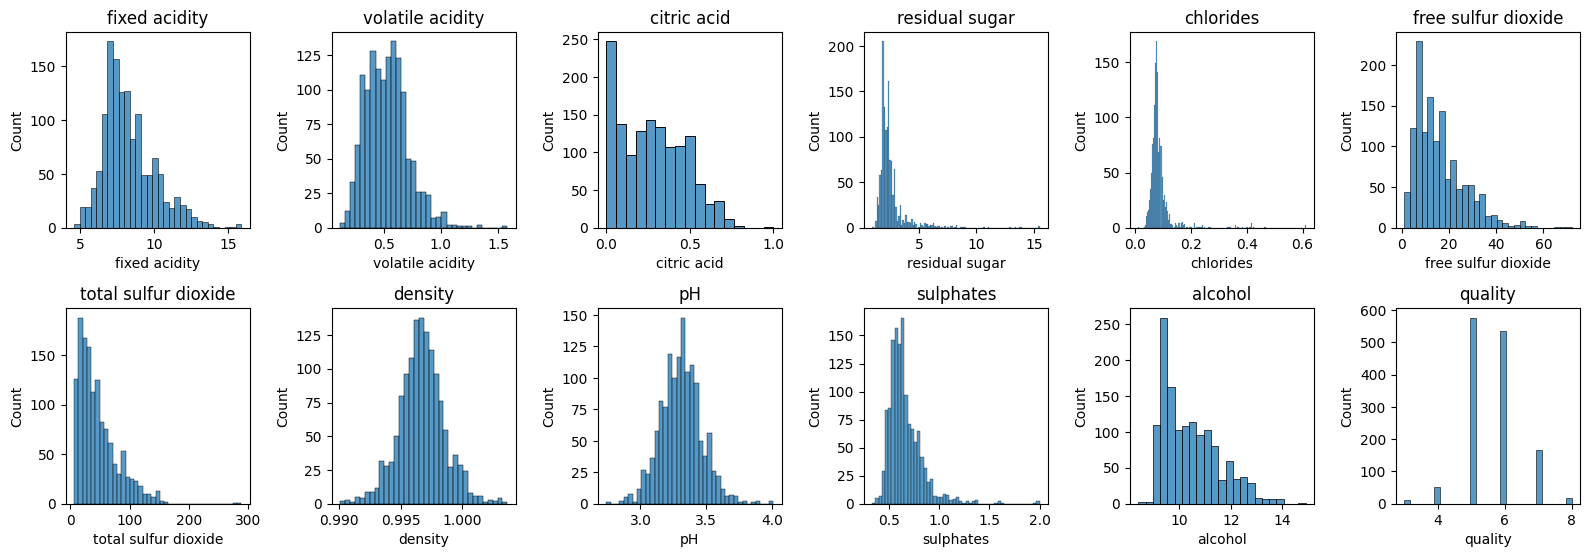

In [13]:
dist_plot_all(df)

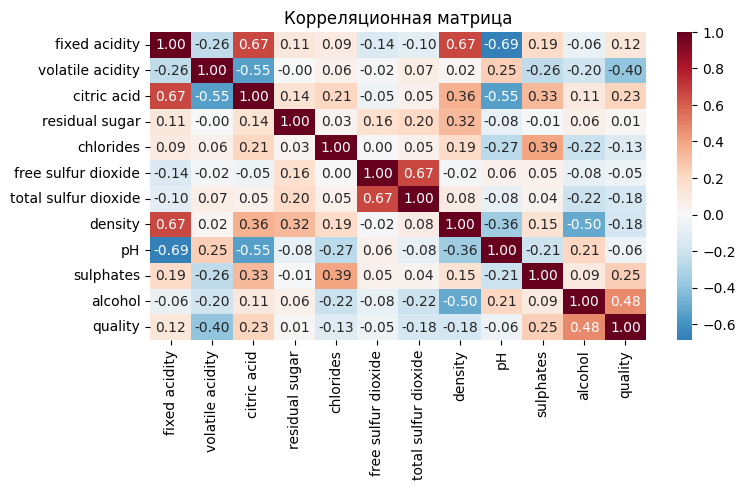

In [14]:
# Корреляции
plt.figure(figsize=(8, 4))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

## Предобработка и создание признаков

Создание новых признаков на основе корреляционного анализа.

In [15]:
df['body_score'] = (df['alcohol'] * df['density'] * df['fixed acidity']) / 100
df['acidity_balance'] = df['fixed acidity'] / (df['volatile acidity'] + 0.01)
df['sulphates_alcohol'] = df['sulphates'] * df['alcohol']
df['ph_acidity_ratio'] = df['pH'] * df['fixed acidity']
df['total_acidity'] = df['fixed acidity'] + df['volatile acidity'] + df['citric acid']
df['sulfur_ratio'] = df['free sulfur dioxide'] / (df['total sulfur dioxide'] + 1)

In [16]:
best_features = [
    'alcohol',
    'volatile acidity',
    'sulphates',
    'citric acid',
    'body_score',
    'acidity_balance',
    'sulphates_alcohol',
    'total_acidity',
    'sulfur_ratio'
]

X = df[best_features]
y = df['quality'].values

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение rf для сравненительной оценки с нейронной сетью
Это необходимо для того, что бы понимать, насколько модель хуже лучше чем классический способ решения такой задачи

In [18]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

## Архитектура нейронной сети

Feedforward нейронная сеть с ReLU активацией, BatchNorm и Dropout.

In [19]:
class WineNet(nn.Module):
    def __init__(self, input_size):
        super(WineNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.6),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.network(x)

In [20]:
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.FloatTensor(y_train.reshape(-1, 1))
y_test_tensor = torch.FloatTensor(y_test.reshape(-1, 1))

## Обучение модели

Градиентный спуск Adam с learning rate scheduling и early stopping.

In [21]:
model = WineNet(len(best_features))
optimizer = optim.Adam(model.parameters(), lr=0.0015, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.7)

val_size = int(0.2 * len(X_train_tensor))
X_train_split = X_train_tensor[:-val_size]
y_train_split = y_train_tensor[:-val_size]
X_val = X_train_tensor[-val_size:]
y_val = y_train_tensor[-val_size:]

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_split)
    loss = criterion(outputs, y_train_split)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1

    if patience_counter >= 50:
        break

    if epoch % 100 == 0:
        print(f'Эпоха {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

model.load_state_dict(best_model_state)

Эпоха 0, Train Loss: 35.4095, Val Loss: 31.6105
Эпоха 100, Train Loss: 1.1987, Val Loss: 0.4939
Эпоха 200, Train Loss: 0.9463, Val Loss: 0.4560
Эпоха 300, Train Loss: 0.8781, Val Loss: 0.4368
Эпоха 400, Train Loss: 0.8318, Val Loss: 0.4294


<All keys matched successfully>

## Результаты и оценка

Сравнение нейронной сети с Random Forest

In [22]:
model.eval()
with torch.no_grad():
    nn_pred = model(X_test_tensor).numpy()

nn_r2 = r2_score(y_test, nn_pred)
nn_mae = mean_absolute_error(y_test, nn_pred)

print(f"Neural Network - R²: {nn_r2:.4f}, MAE: {nn_mae:.4f}")
print(f"Random Forest - R²: {rf_r2:.4f}, MAE: {rf_mae:.4f}")

Neural Network - R²: 0.3852, MAE: 0.4979
Random Forest - R²: 0.3729, MAE: 0.5116


## Анализ важности признаков

Для понимания того, какие химические характеристики наиболее влияют на качество вина, проводим анализ важности признаков методом Permutation Importance.

In [23]:
feature_importance = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': best_features,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nВажность признаков (Random Forest):")
print(importance_df)


Важность признаков (Random Forest):
             feature  importance
6  sulphates_alcohol    0.339305
0            alcohol    0.168511
1   volatile acidity    0.110798
5    acidity_balance    0.084906
8       sulfur_ratio    0.082389
4         body_score    0.060699
3        citric acid    0.054833
7      total_acidity    0.050328
2          sulphates    0.048231


In [24]:
def calculate_nn_feature_importance(model, X_test, y_test):
    model.eval()

    with torch.no_grad():
        baseline_pred = model(X_test).numpy()
    baseline_mae = mean_absolute_error(y_test, baseline_pred)

    feature_importance = []

    for i in range(X_test.shape[1]):
        X_permuted = X_test.clone()
        X_permuted[:, i] = X_permuted[torch.randperm(X_permuted.size(0)), i]

        with torch.no_grad():
            permuted_pred = model(X_permuted).numpy()
        permuted_mae = mean_absolute_error(y_test, permuted_pred)

        importance = permuted_mae - baseline_mae
        feature_importance.append(importance)

    return np.array(feature_importance)

nn_feature_importance = calculate_nn_feature_importance(model, X_test_tensor, y_test)

nn_importance_df = pd.DataFrame({
    'feature': best_features,
    'importance': nn_feature_importance
}).sort_values('importance', ascending=False)

print("\nВажность признаков (Нейронная сеть):")
print(nn_importance_df)


Важность признаков (Нейронная сеть):
             feature  importance
0            alcohol    0.076285
8       sulfur_ratio    0.046937
1   volatile acidity    0.043301
5    acidity_balance    0.020611
7      total_acidity    0.020428
2          sulphates    0.020197
6  sulphates_alcohol    0.017909
4         body_score    0.014826
3        citric acid    0.010018


## Визуализация результатов

Графики предсказаний, кривых обучения и распределения остатков.

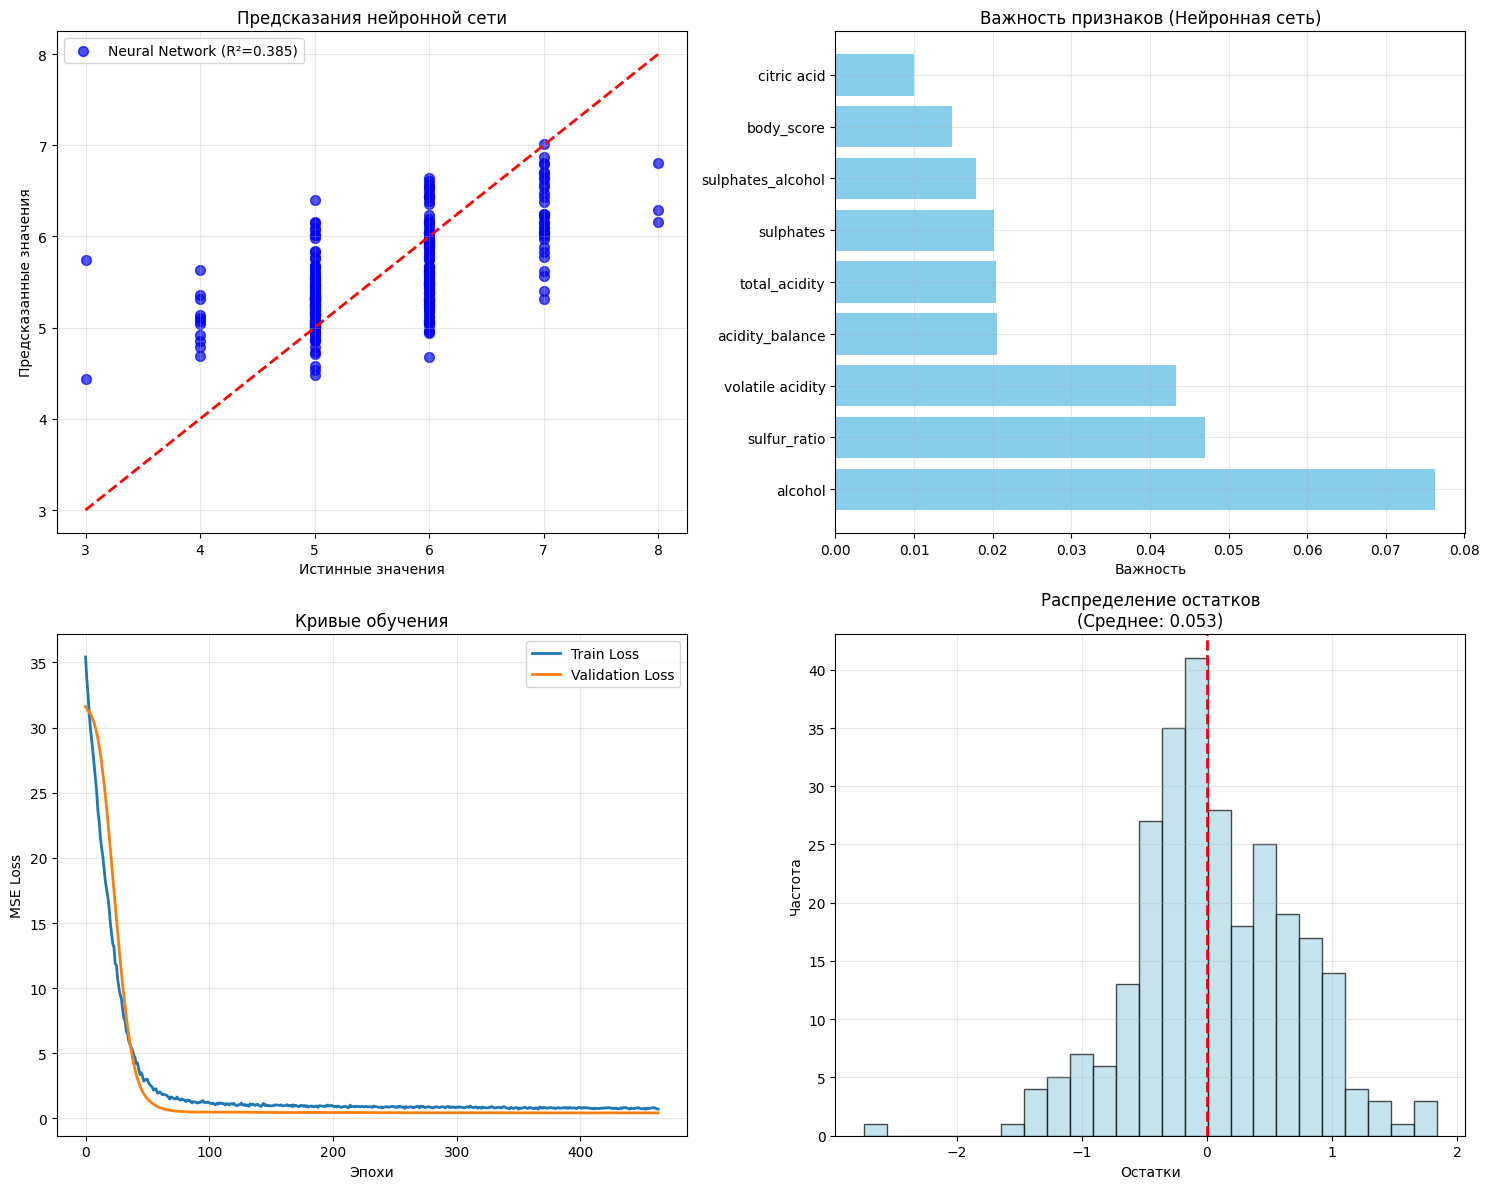

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0,0].scatter(y_test, nn_pred, alpha=0.7, s=50, label=f'Neural Network (R²={nn_r2:.3f})', color='blue')
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Истинные значения')
axes[0,0].set_ylabel('Предсказанные значения')
axes[0,0].set_title('Предсказания нейронной сети')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].barh(nn_importance_df['feature'], nn_importance_df['importance'], color='skyblue')
axes[0,1].set_title('Важность признаков (Нейронная сеть)')
axes[0,1].set_xlabel('Важность')
axes[0,1].grid(True, alpha=0.3)

axes[1,0].plot(train_losses, label='Train Loss', linewidth=2)
axes[1,0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[1,0].set_title('Кривые обучения')
axes[1,0].set_xlabel('Эпохи')
axes[1,0].set_ylabel('MSE Loss')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

nn_residuals = y_test - nn_pred.flatten()
axes[1,1].hist(nn_residuals, bins=25, alpha=0.7, color='lightblue', edgecolor='black')
axes[1,1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1,1].set_xlabel('Остатки')
axes[1,1].set_ylabel('Частота')
axes[1,1].set_title(f'Распределение остатков\n(Среднее: {nn_residuals.mean():.3f})')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()